In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (set_init_point, prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad, create_organo
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


ImportError: cannot import name 'create_organo'

Reseting datasets values with new specs


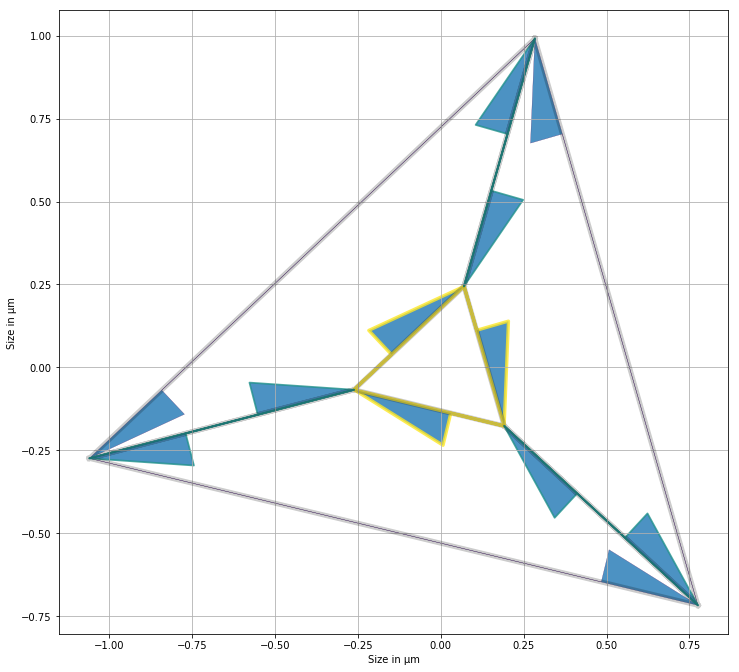

In [5]:
nb_cells = 3
r_in = 1
r_out = 4
seed = 1553
organo = generate_ring(nb_cells, r_in, r_out)
Nf= organo.Nf
geom.update_all(organo)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  alpha*organo.face_df.area, 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.001,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
organo.edge_df.loc[:nb_cells, 'line_tension'] *= 2
organo.edge_df.loc[nb_cells:2*nb_cells-1, 'line_tension'] = 0
organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(np.pi/12) -
                              organo.vert_df.y.copy() * np.sin(np.pi/12))
organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(np.pi/12) +
                              organo.vert_df.y.copy() * np.cos(np.pi/12))
normalize_scale(organo, geom, refer='edges')
geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

Compute the gradients for each edge's srce and trgt

In [6]:
grad_srce, grad_trgt = area_grad(organo)
grad_lumen_srce, grad_lumen_trgt = lumen_area_grad(organo)
Solver.find_energy_min(organo, geom, model)

      fun: 0.003761378151633987
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.44139213e-04, -4.69408445e-04, -9.25231302e-04, -1.41658210e-04,
        3.87732037e-04,  8.69662871e-04, -3.98263582e-04,  2.58854289e-04,
        2.93289689e-04,  3.62337759e-05, -2.01666056e-04, -5.53684281e-04])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 1
      nit: 0
   status: 0
  success: True
        x: array([ 0.19123401, -0.1765332 , -0.26122041, -0.0675512 ,  0.07002808,
        0.24411645,  0.7757252 , -0.71757141, -1.05961867, -0.27443538,
        0.28385179,  0.99197474])

In [8]:
grad_lumen_srce, grad_lumen_trgt = lumen_area_grad(organo)
grouped_lumen_srce = grad_lumen_srce.groupby(organo.edge_df.srce)
grouped_lumen_trgt = grad_lumen_trgt.groupby(organo.edge_df.trgt)
lumen_coef = np.zeros(2*organo.Nv)
for vertex in range(organo.Nv):
    adj_lumen_srce = grouped_lumen_srce.get_group(
        list(grouped_lumen_srce.groups.keys())[vertex])
    adj_lumen_trgt = grouped_lumen_trgt.get_group(
        list(grouped_lumen_trgt.groups.keys())[vertex])[::-1]
    lumen_coef[vertex] = np.sum((adj_lumen_srce.gx, adj_lumen_trgt.gx))
    lumen_coef[organo.Nv+vertex] = np.sum((adj_lumen_srce.gy, adj_lumen_trgt.gy))

In [9]:
lumen_coef

array([ 0.31166765, -0.42064965,  0.108982  ,  0.        ,  0.        ,
        0.        , -0.3312485 , -0.12120593,  0.45245442,  0.        ,
        0.        ,  0.        ])

Use groupby to arrange the gradient vectors according to the srce/trgt

In [10]:
grouped_srce = grad_srce.groupby(organo.edge_df.srce)
grouped_trgt = grad_trgt.groupby(organo.edge_df.trgt)
grouped_lumen_srce = grad_lumen_srce.groupby(organo.edge_df.srce)
grouped_lumen_trgt = grad_lumen_trgt.groupby(organo.edge_df.trgt)
for vertex in range(organo.Nv)[:2]:
    to_print_groupby = grouped_srce.get_group(list(grouped_srce.groups.keys())[vertex])
    print("Both edges have the same srce:\n", to_print_groupby)
    print("Indeed in organo.edge_df we have:\n", organo.edge_df.loc[to_print_groupby.index, 'srce'])

Both edges have the same srce:
             gx        gy
edge                    
0     0.120736  0.086375
11   -0.401534 -0.222758
Indeed in organo.edge_df we have:
 edge
0     0
11    0
Name: srce, dtype: int64
Both edges have the same srce:
             gx        gy
edge                    
1     0.010295 -0.155884
9     0.017294  0.485574
Indeed in organo.edge_df we have:
 edge
1    1
9    1
Name: srce, dtype: int64


Populate area_coefs with the gradients : first vertex

First we extract the corresponding groups from the groupby object

In [11]:
area_coefs = np.zeros((2*organo.Nv, organo.Nf+1))
vertex = 0
adj_srce = grouped_srce.get_group(list(grouped_srce.groups.keys())[vertex])
adj_trgt = grouped_trgt.get_group(list(grouped_trgt.groups.keys())[vertex])[::-1]
adj_lumen_srce = grouped_lumen_srce.get_group(list(grouped_lumen_srce.groups.keys())[vertex])
adj_lumen_trgt = grouped_lumen_trgt.get_group(list(grouped_lumen_trgt.groups.keys())[vertex])[::-1]

print("The groups match with the chosen vertex:\n",
      adj_srce, adj_trgt, adj_lumen_srce, adj_lumen_trgt,
      "\n\nThe srce/trgt of the edges in the indexes are the chosen vertex:\n",
      organo.edge_df.loc[adj_srce.index, 'srce'], organo.edge_df.loc[adj_trgt.index, 'trgt'])

The groups match with the chosen vertex:
             gx        gy
edge                    
0     0.120736  0.086375
11   -0.401534 -0.222758             gx        gy
edge                    
6     0.204274  0.432098
2    -0.079310 -0.130091             gx       gy
edge                   
0     0.067551 -0.26122
11   -0.000000  0.00000             gx        gy
edge                    
6     0.000000 -0.000000
2     0.244116 -0.070028 

The srce/trgt of the edges in the indexes are the chosen vertex:
 edge
0     0
11    0
Name: srce, dtype: int64 edge
6    0
2    0
Name: trgt, dtype: int64


Placing the obtained coefficients in the matrix

In [12]:
coefs_cols = organo.edge_df.loc[adj_srce.index, 'face']
area_coefs[vertex][coefs_cols] += (adj_srce.gx.values +
                                  adj_trgt.gx.values)
area_coefs[organo.Nv+vertex][coefs_cols] += (adj_srce.gy.values +
                                            adj_trgt.gy.values)
area_coefs[vertex][organo.Nf] += np.sum((adj_lumen_srce.gx,
                                       adj_lumen_trgt.gx))
area_coefs[organo.Nv+vertex][organo.Nf] += np.sum((adj_lumen_srce.gy,
                                                  adj_lumen_trgt.gy))
area_elasticity = np.tile(np.hstack([organo.face_df.area_elasticity,
                                     organo.settings['lumen_elasticity']]),
                          (2*organo.Nv, 1))
area_coefs = np.multiply(area_coefs, area_elasticity)

print("The matrix is properly modified :\n", area_coefs)

The matrix is properly modified :
 [[ 0.3250101   0.         -0.48084393  0.03116677]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.51847281  0.         -0.35284856 -0.03312485]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


Now we repeat this process for all remaining vertices

In [13]:
for vertex in range(1, organo.Nv):
    adj_srce = grouped_srce.get_group(
        list(grouped_srce.groups.keys())[vertex])
    adj_trgt = grouped_trgt.get_group(
        list(grouped_trgt.groups.keys())[vertex])[::-1]
    adj_lumen_srce = grouped_lumen_srce.get_group(
        list(grouped_lumen_srce.groups.keys())[vertex])
    adj_lumen_trgt = grouped_lumen_trgt.get_group(
        list(grouped_lumen_trgt.groups.keys())[vertex])[::-1]
    coefs_cols = organo.edge_df.loc[adj_srce.index, 'face']
    area_coefs[vertex][coefs_cols] += (adj_srce.gx.values +
                                      adj_trgt.gx.values)
    area_coefs[organo.Nv+vertex][coefs_cols] += (adj_srce.gy.values +
                                                adj_trgt.gy.values)
    area_coefs[vertex][organo.Nf] += np.sum((adj_lumen_srce.gx,
                                           adj_lumen_trgt.gx))
    area_coefs[organo.Nv+vertex][organo.Nf] += np.sum((adj_lumen_srce.gy,
                                                      adj_lumen_trgt.gy))
area_elasticity = np.tile(np.hstack([organo.face_df.area_elasticity,
                                     organo.settings['lumen_elasticity']]),
                          (2*organo.Nv, 1))

area_coefs = np.multiply(area_coefs, area_elasticity)

print("We obtain the following result :\n", area_coefs)

We obtain the following result :
 [[ 0.3250101   0.         -0.48084393  0.00311668]
 [-0.04895109  0.25927592  0.         -0.04206496]
 [ 0.          0.52976297 -0.58425397  0.0108982 ]
 [ 0.04895109  0.          0.58425397  0.        ]
 [-0.3250101  -0.52976297  0.          0.        ]
 [ 0.         -0.25927592  0.48084393  0.        ]
 [ 0.51847281  0.         -0.35284856 -0.00331248]
 [ 0.62542634 -0.56482337  0.         -0.01212059]
 [ 0.         -0.2725361   0.04630889  0.04524544]
 [-0.62542634  0.         -0.04630889  0.        ]
 [-0.51847281  0.2725361   0.          0.        ]
 [ 0.          0.56482337  0.35284856  0.        ]]


We compute the gradients explicitly to verify the coefficients

In [14]:
grad_calc = organo.copy()
grad_calc.vert_df.loc[0, 'x'] += 0.0001
geom.update_all(grad_calc)
Solver.find_energy_min(grad_calc, geom, model)
print("The coefficients are approx. equal to the estimated gradients :\n",
      (grad_calc.face_df.area[0]-organo.face_df.area[0])/0.0001, " ~ ",
      area_coefs[0][0])    

The coefficients are approx. equal to the estimated gradients :
 0.3250101022045371  ~  0.3250101022046616


We repeat this experiment for all vertices and areas

In [15]:
mistake = False
area_coef_x = {}
area_coef_y = {}
for vertex in range(organo.Nv):
    for face in range(organo.Nf):
        grad_calc = organo.copy()
        grad_calc.vert_df.loc[vertex, 'x'] += 0.001
        geom.update_all(grad_calc)
        Solver.find_energy_min(grad_calc, geom, model)
        area_coef_x[(vertex, face)] = (grad_calc.face_df.area[face]-organo.face_df.area[face])/0.001
        grad_calc = organo.copy()
        grad_calc.vert_df.loc[vertex, 'y'] += 0.001
        geom.update_all(grad_calc)
        Solver.find_energy_min(grad_calc, geom, model)
        area_coef_y[(vertex, face)] = (grad_calc.face_df.area[face]-organo.face_df.area[face])/0.001
print("There are mistakes: mistake =", mistake)

There are mistakes: mistake = False


In [16]:
mistake = False
edge_coef_x = {}
edge_coef_y = {}
for vertex in range(organo.Nv):
    for edge in range(organo.Nf*3):
        grad_calc = organo.copy()
        grad_calc.vert_df.loc[vertex, 'x'] += 0.001
        geom.update_all(grad_calc)
        Solver.find_energy_min(grad_calc, geom, model)
        edge_coef_x[(vertex, edge)] = (grad_calc.edge_df.length[edge]-organo.edge_df.length[edge])/0.001
        grad_calc = organo.copy()
        grad_calc.vert_df.loc[vertex, 'y'] += 0.001
        geom.update_all(grad_calc)
        Solver.find_energy_min(grad_calc, geom, model)
        edge_coef_y[(vertex, edge)] = ((grad_calc.edge_df.length[edge]-organo.edge_df.length[edge])/0.001)
print("There are mistakes: mistake =", mistake)

There are mistakes: mistake = False


In [17]:
edge_mat_x = np.reshape(list(edge_coef_x.values()), (organo.Nv, 3*organo.Nf))
edge_mat_y = np.reshape(list(edge_coef_y.values()), (organo.Nv, 3*organo.Nf))
area_mat_x = np.reshape(list(area_coef_x.values()), (organo.Nv, organo.Nf))
area_mat_y = np.reshape(list(area_coef_y.values()), (organo.Nv, organo.Nf))
edge_mat = np.vstack((edge_mat_x, edge_mat_y))
area_mat = np.vstack((area_mat_x, area_mat_y))
coef_mat = np.zeros((organo.Nv*2+1, organo.Nf+1+organo.Nf*3))
for i in range(coef_mat.shape[0]-1):
    for j in range(coef_mat.shape[1]-1):
        coef_mat[i][j] = np.hstack((edge_mat, area_mat))[i][j]
for i in range(coef_mat.shape[0]-1):
     coef_mat[i][coef_mat.shape[1]-1] = lumen_coef[i]
for j in range(coef_mat.shape[1]-1):
    if j < organo.Nf*3:
        coef_mat[coef_mat.shape[0]-1][j] = 1
print(coef_mat)

[[-1.16206946e+00 -1.73405718e+00 -8.29877775e-01  8.76763727e-01
   8.56978774e-01  8.32625503e-01  7.76320563e-01  1.05813829e+00
   1.82743552e+00 -2.73427104e-05  5.90995505e-01  1.25015911e+00
   3.11667650e-01]
 [-9.72136340e-01 -7.27787889e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  9.68066789e-01
   0.00000000e+00 -4.89510911e-02  2.59275915e-01  0.00000000e+00
  -4.20649648e-01]
 [-1.82564761e+00 -1.37234143e+00 -1.23963936e+00  7.55959582e-01
   9.00312568e-01  7.49184865e-01  1.74633871e+00  9.36360793e-01
   1.29214230e+00  3.22332237e-01  1.95981226e-01  1.32921018e+00
   1.08981998e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.72082050e-01
   0.00000000e+00  2.76763693e-01  7.34148568e-01  0.00000000e+00
   0.00000000e+00  4.89510911e-02  0.00000000e+00  5.84253969e-01
   0.00000000e+00]
 [-1.87429829e+00 -1.56646916e+00 -1.76217804e+00  1.85399701e-01
   4.39402555e-01  1.35869168e+00  1.59259173e+00  7.29685737e-01


In [18]:
from tyssue_taylor.adjusters.force_inference import _right_side
right_side = _right_side(organo, coef_mat)

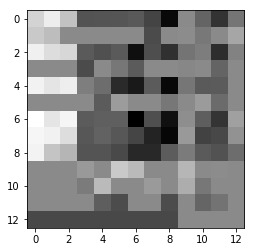

In [19]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.imshow(coef_mat, cmap='Greys')

In [20]:
system_sol = np.linalg.solve(coef_mat, _right_side(organo, coef_mat))

In [25]:
from scipy.optimize import nnls
res, _ = nnls(coef_mat, _right_side(organo, coef_mat))
print(res)

[0.00174738 0.00186937 0.         0.         0.         0.
 0.00098947 0.00268049 0.00114731 0.         0.         0.
 0.        ]


Now lets verify the lumen coefs that are very low

In [25]:
grad_calc = organo.copy()
grad_calc.vert_df.loc[0, 'x'] += 0.001
geom.update_all(grad_calc)
Solver.find_energy_min(grad_calc, geom, model)
print("The coefficients are approx. equal to the estimated gradients :\n",
      (grad_calc.settings['lumen_volume']-organo.settings['lumen_volume'])/0.001, " ~ ",
      area_coefs[0][-1])    

The coefficients are approx. equal to the estimated gradients :
 0.0  ~  0.00311667650491342


This is troubling. There must be an input missing to update the lumen parameters.

In [ ]:
mistake = False
for vertex in range(organo.Nv):
    grad_calc = organo.copy()
    grad_calc.vert_df.loc[vertex, 'x'] += 0.001
    geom.update_all(grad_calc) 
    print(vertex, face, round(area_coefs[vertex][-1], 4),
         round((grad_calc.settings['lumen_volume']-organo.settings['lumen_volume'])/0.001, 4))
    if (round(area_coefs[vertex][-1], 4) !=
        round((grad_calc.settings['lumen_volume']-organo.settings['lumen_volume'])/0.001, 4)):
        mistake = True
    grad_calc = organo.copy()
    grad_calc.vert_df.loc[vertex, 'y'] += 0.001
    geom.update_all(grad_calc)
    print(vertex, face, round(area_coefs[vertex+organo.Nv][-1], 4),
         round((grad_calc.settings['lumen_volume']-organo.settings['lumen_volume'])/0.001, 4)) 
    if (round(area_coefs[vertex+organo.Nv][-1], 4) !=
        round((grad_calc.settings['lumen_volume']-organo.settings['lumen_volume'])/0.001, 4)):
        mistake = True
print("There is no mistake: mistake =", mistake)

In [26]:
coefs_tensions = _coef_matrix(organo, '')
coefs = np.hstack((coefs_tensions, area_coefs))
constant = _right_side(organo, coefs)
real_param = np.concatenate((organo.edge_df.line_tension[:3*organo.Nf],
                             organo.face_df.area -
                             organo.face_df.prefered_area,
                             [organo.settings['lumen_volume'] -
                              organo.settings['lumen_prefered_vol']]))

In [27]:
print('At-b: ', np.dot(coefs, real_param) - constant)

At-b:  [-4.96933418e-03  2.28071341e-03 -3.84098672e-03 -1.86598187e-03
 -1.94268529e-03 -7.51464668e-04 -1.49646242e-03 -2.48188232e-03
 -5.60363308e-03  1.61745762e-03  5.37912784e-04 -2.47663032e-03
  1.73472348e-18]
